In [1]:
# this notebook predicts the sentiments of tweets regarding the GOP presidential debate 2016
# data obtained from Crowdflower's "Data For Everyone" library: https://www.figure-eight.com/data-for-everyone/

In [2]:
# part 1: use naive bayes to predict tweet sentiment

In [3]:
%reset -f

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from nltk.tokenize import word_tokenize

np.random.seed(123)

In [4]:
# import dataset
full = pd.read_csv('../data/GOP_presidential_debate_2016_tweets/Sentiment.csv')

# keep only relevant columns
full = full[['sentiment','text']]

# let's try binary classification for this project; drop tweets that have neutral sentiment
full = full.loc[(full['sentiment']!='Neutral'),]

# shuffle rows (we'll be splitting data into train and test sets later)
full = full.sample(frac=1)

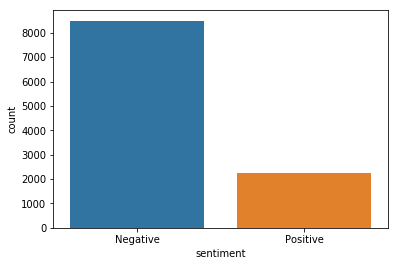

In [5]:
# plot frequencies of positive and negative tweets
sns.countplot(x='sentiment', data=full) # most tweets are negative

In [6]:
# clean the tweets: transform all words to lowercase, keep only words with at least 3 letters, remove words that contain http or start with @ or start with # or is 'RT', remove punctuation
full_cleaned = []
english_stopwords = set(stopwords.words("english"))

import string

for index, row in full.iterrows():
    words_cleaned = [e.lower() for e in row.text.split() if len(e) >= 3] # keep only those words with at least 3 letters
    words_cleaned = [word for word in words_cleaned
        if 'http' not in word
        and not word.startswith('@')
        and not word.startswith('#')
        and word != 'RT']
    words_cleaned = [word.translate(str.maketrans({key: None for key in string.punctuation})) for word in words_cleaned] # remove punctuation
    words_cleaned = [word for word in words_cleaned if not word in english_stopwords] # remove stopwords
    words_cleaned = dict([(word, True) for word in words_cleaned])
    full_cleaned.append((words_cleaned, row.sentiment))

In [7]:
# split the data into train and test sets
samp_prop = 0.8
train = full_cleaned[0:int(len(full_cleaned)*samp_prop)]
test = full_cleaned[int(len(full_cleaned)*samp_prop):]

# Training the Naive Bayes classifier
classifier = nltk.NaiveBayesClassifier.train(train)

In [8]:
# check train accuracy
accuracy = nltk.classify.util.accuracy(classifier, train)
print('the percentage of training obs predicted correctly is:', round(accuracy * 100,1))

# check test accuracy
accuracy = nltk.classify.util.accuracy(classifier, test)
print('the percentage of test obs predicted correctly is:', round(accuracy * 100,1))

the percentage of training obs predicted correctly is: 88.0
the percentage of test obs predicted correctly is: 78.8


In [9]:
# see predicted sentiments for first 10 obs in the test set
for i in range(0,10):
    print(classifier.classify(test[i][0]))

print('-'*30)

# compare against actual sentiments for first 10 obs in the test set
for i in range(0,10):
    print(test[i][1])

print('-'*30)

# store predictions in a list
predictions = []
for i in range(0,len(test)):
    pred = classifier.classify(test[i][0])
    predictions.append(pred)

Positive
Positive
Positive
Negative
Negative
Positive
Negative
Negative
Negative
Negative
------------------------------
Negative
Negative
Negative
Negative
Negative
Positive
Negative
Negative
Negative
Negative
------------------------------


In [10]:
# part 2: use AFINN lexicon to predict tweet sentiment

In [11]:
# use AFINN to assign a sentiment score to each tweet
from afinn import Afinn

afinn_scores = []

for index, row in full.iterrows():
    afinn_score = Afinn().score(row.text)
    afinn_scores.append(afinn_score)

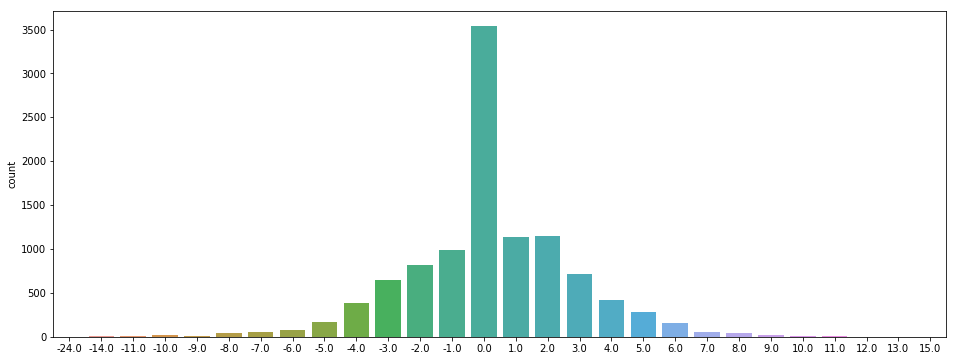

In [12]:
# set the desired size of the graph
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)

# plot the frequencies of sentiment scores
sns.countplot(afinn_scores, ax=ax) # seems like there are lots of tweets that are deemed neutral by AFINN

In [13]:
# convert sentiment scores above zero to Positive. convert sentiment scores at/below zero to Negative (since negative tweets are more common than positive tweets).
full['afinn_score'] = afinn_scores

full['afinn_sentiment'] = ''
full.loc[(full['afinn_score']>0),'afinn_sentiment'] = 'Positive'
full.loc[(full['afinn_score']<=0),'afinn_sentiment'] = 'Negative'

# generate a variable that shows whether the AFINN sentiment is correct
full['afinn_correct'] = ''
full.loc[(full['afinn_sentiment']==full['sentiment']),'afinn_correct'] = 'Correct'
full.loc[(full['afinn_sentiment']!=full['sentiment']),'afinn_correct'] = 'Wrong'

# see the proportion of predictions that AFINN got correct
print(full['afinn_correct'].value_counts() / full.shape[0]) # about 66% of AFINN's sentiment predictions are correct

Correct    0.659055
Wrong      0.340945
Name: afinn_correct, dtype: float64


In [14]:
# part 3: use VADER to predict tweet sentiment
# details of the VADER sentiment analysis method can be found in the paper below:
# Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

In [15]:
# use VADER to assign a sentiment score to each tweet
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as sia

vader_scores = []

for index, row in full.iterrows():
    vader_score = sia().polarity_scores(row.text)['compound']
    vader_scores.append(vader_score)

C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


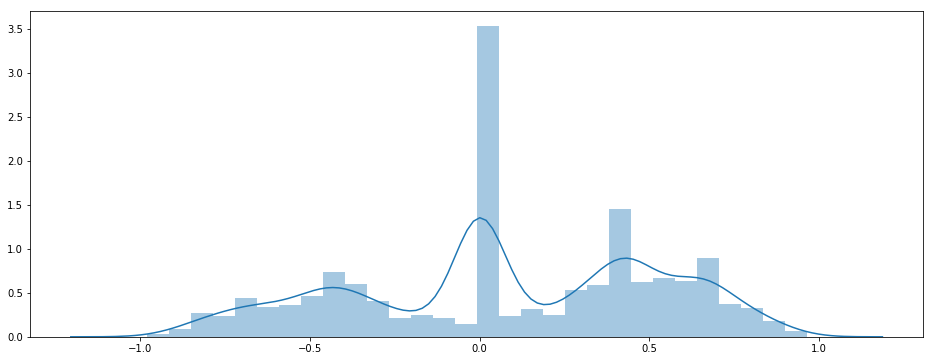

In [16]:
# set the desired size of the graph
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)

# plot the distribution of sentiment scores
sns.distplot(vader_scores, ax=ax) # seems like there are lots of tweets that are deemed neutral by VADER

In [17]:
# convert sentiment scores above zero to Positive. convert sentiment scores at/below zero to Negative (since negative tweets are more common than positive tweets).
full['vader_score'] = vader_scores

full['vader_sentiment'] = ''
full.loc[(full['vader_score']>0),'vader_sentiment'] = 'Positive'
full.loc[(full['vader_score']<=0),'vader_sentiment'] = 'Negative'

# generate a variable that shows whether the AFINN sentiment is correct
full['vader_correct'] = ''
full.loc[(full['vader_sentiment']==full['sentiment']),'vader_correct'] = 'Correct'
full.loc[(full['vader_sentiment']!=full['sentiment']),'vader_correct'] = 'Wrong'

# see the proportion of predictions that AFINN got correct
print(full['vader_correct'].value_counts() / full.shape[0]) # about 62% of VADER's sentiment predictions are correct

Correct    0.618138
Wrong      0.381862
Name: vader_correct, dtype: float64
